In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

filename = 'NF-CICIDS2018-v3'

df = pd.read_csv(f'db/{filename}.csv')

df.drop(['IPV4_SRC_ADDR',
         'IPV4_DST_ADDR',
         'L4_SRC_PORT',
         'L4_DST_PORT',
         'L7_PROTO',
         'TCP_FLAGS',
         'CLIENT_TCP_FLAGS',
         'SERVER_TCP_FLAGS',
         'MIN_TTL', 
         'MAX_TTL',
         'SHORTEST_FLOW_PKT',
         'MIN_IP_PKT_LEN', 
         'TCP_WIN_MAX_IN', 
         'TCP_WIN_MAX_OUT', 
         'DNS_QUERY_ID', 
         'DNS_TTL_ANSWER',
         'FTP_COMMAND_RET_CODE',
         'SRC_TO_DST_SECOND_BYTES',
         'DST_TO_SRC_SECOND_BYTES',
         'FLOW_START_MILLISECONDS',
         'FLOW_END_MILLISECONDS',], inplace=True, axis=1)

dictionary_sets_by_attack_type = {}
attack_types = df['Attack'].unique()

for attack_type in attack_types:
    print(f"Processando a categoria: '{attack_type}'")
    df_current_attack = df[df['Attack'] == attack_type]

    df_train_current_attack, df_aux_current_attack = train_test_split(df_current_attack, train_size=0.5, random_state=42)
    df_test_current_attack, df_val_current_attack = train_test_split(df_aux_current_attack, train_size=0.5, random_state=42)

    dictionary_sets_by_attack_type[attack_type] = {
        'treino': df_train_current_attack,
        'teste': df_test_current_attack,
        'validacao': df_val_current_attack
    }
    print(f"  -> Treino: {len(df_train_current_attack)} | Teste: {len(df_test_current_attack)} | Validação: {len(df_val_current_attack)}")


np.random.seed(42)

attack_types = np.delete(attack_types, np.where(attack_types == 'Benign'))
np.random.shuffle(attack_types)

attack_types_for_train, attack_types_for_test, attack_types_for_val = np.split(
    attack_types,
    [
        int(len(attack_types) * 0.5),
        int(len(attack_types) * 0.75)
    ]
)

attack_types_for_train = np.append(attack_types_for_train, 'Benign')
attack_types_for_test = np.append(attack_types_for_test, 'Benign')
attack_types_for_val = np.append(attack_types_for_val, 'Benign')

print(f"Categorias para a base de TREINO FINAL: {list(attack_types_for_train)}")
print(f"Categorias para a base de TESTE FINAL: {list(attack_types_for_test)}")
print(f"Categorias para a base de VALIDAÇÃO FINAL: {list(attack_types_for_val)}")

Processando a categoria: 'Benign'
  -> Treino: 8757313 | Teste: 4378656 | Validação: 4378657
Processando a categoria: 'FTP-BruteForce'
  -> Treino: 193360 | Teste: 96680 | Validação: 96680
Processando a categoria: 'SSH-Bruteforce'
  -> Treino: 94237 | Teste: 47118 | Validação: 47119
Processando a categoria: 'DoS_attacks-GoldenEye'
  -> Treino: 30650 | Teste: 15325 | Validação: 15325
Processando a categoria: 'DoS_attacks-Slowloris'
  -> Treino: 18020 | Teste: 9010 | Validação: 9010
Processando a categoria: 'DoS_attacks-SlowHTTPTest'
  -> Treino: 52775 | Teste: 26387 | Validação: 26388
Processando a categoria: 'DoS_attacks-Hulk'
  -> Treino: 50038 | Teste: 25019 | Validação: 25019
Processando a categoria: 'DDoS_attacks-LOIC-HTTP'
  -> Treino: 144294 | Teste: 72147 | Validação: 72148
Processando a categoria: 'DDOS_attack-LOIC-UDP'
  -> Treino: 1725 | Teste: 862 | Validação: 863
Processando a categoria: 'DDOS_attack-HOIC'
  -> Treino: 516155 | Teste: 258078 | Validação: 258078
Processando 

In [56]:
list_train = [dictionary_sets_by_attack_type[attack_type]['treino'] for attack_type in attack_types_for_train]
df_train = pd.concat(list_train)

list_test = [dictionary_sets_by_attack_type[attack_type]['teste'] for attack_type in attack_types_for_test]
df_test = pd.concat(list_test)

list_val = [dictionary_sets_by_attack_type[attack_type]['validacao'] for attack_type in attack_types_for_val]
df_val = pd.concat(list_val)

print(f"--- Base de Treino ---")
print(f"Tamanho: {len(df_train)} linhas")
print(f"Categorias presentes: {df_train['Attack'].unique()}")
print(df_train['Attack'].value_counts())
print("-" * 25)

print(f"\n--- Base de Teste ---")
print(f"Tamanho: {len(df_test)} linhas")
print(f"Categorias presentes: {df_test['Attack'].unique()}")
print(df_test['Attack'].value_counts())
print("-" * 25)

print(f"\n--- Base de Validação ---")
print(f"Tamanho: {len(df_val)} linhas")
print(f"Categorias presentes: {df_val['Attack'].unique()}")
print(df_val['Attack'].value_counts())
print("-" * 25)

--- Base de Treino ---
Tamanho: 9642621 linhas
Categorias presentes: ['Brute_Force_-Web' 'SQL_Injection' 'FTP-BruteForce' 'Infilteration'
 'DoS_attacks-Hulk' 'DDOS_attack-HOIC' 'DoS_attacks-GoldenEye' 'Benign']
Attack
Benign                   8757313
DDOS_attack-HOIC          516155
FTP-BruteForce            193360
Infilteration              94076
DoS_attacks-Hulk           50038
DoS_attacks-GoldenEye      30650
Brute_Force_-Web             809
SQL_Injection                220
Name: count, dtype: int64
-------------------------

--- Base de Teste ---
Tamanho: 4504087 linhas
Categorias presentes: ['SSH-Bruteforce' 'Bot' 'DoS_attacks-SlowHTTPTest' 'Benign']
Attack
Benign                      4378656
Bot                           51926
SSH-Bruteforce                47118
DoS_attacks-SlowHTTPTest      26387
Name: count, dtype: int64
-------------------------

--- Base de Validação ---
Tamanho: 4460798 linhas
Categorias presentes: ['DDOS_attack-LOIC-UDP' 'Brute_Force_-XSS' 'DoS_attacks-Slow

In [57]:
scaler = MinMaxScaler()

df_train_benign = df_train[df_train['Attack'] == 'Benign']
df_train_attacks = df_train[df_train['Attack'] != 'Benign']

rus = df_train_attacks['Attack'].value_counts().min()
if rus < 1000:
    rus = 1000

df_train_attacks_balanced = df_train_attacks.groupby('Attack').sample(n=rus, replace=True, random_state=42)

num_attack_classes = len(df_train_attacks['Attack'].unique())
num_benign_samples = num_attack_classes * rus
df_train_benign_sampled = df_train_benign.sample(n=num_benign_samples, random_state=42)

df_train = pd.concat([df_train_attacks_balanced, df_train_benign_sampled])
df_train = shuffle(df_train, random_state=42).reset_index(drop=True)

feature_names = df_train.columns


X_train = df_train.drop(['Label', 'Attack'], axis=1)
y_train = df_train['Label'].to_numpy()

X_train = scaler.fit_transform(X_train)

/tmp/ipykernel_28453/3693294284.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(


Text(0.5, 1.03, "Distribuição das Features (Comparando por 'Attack')")

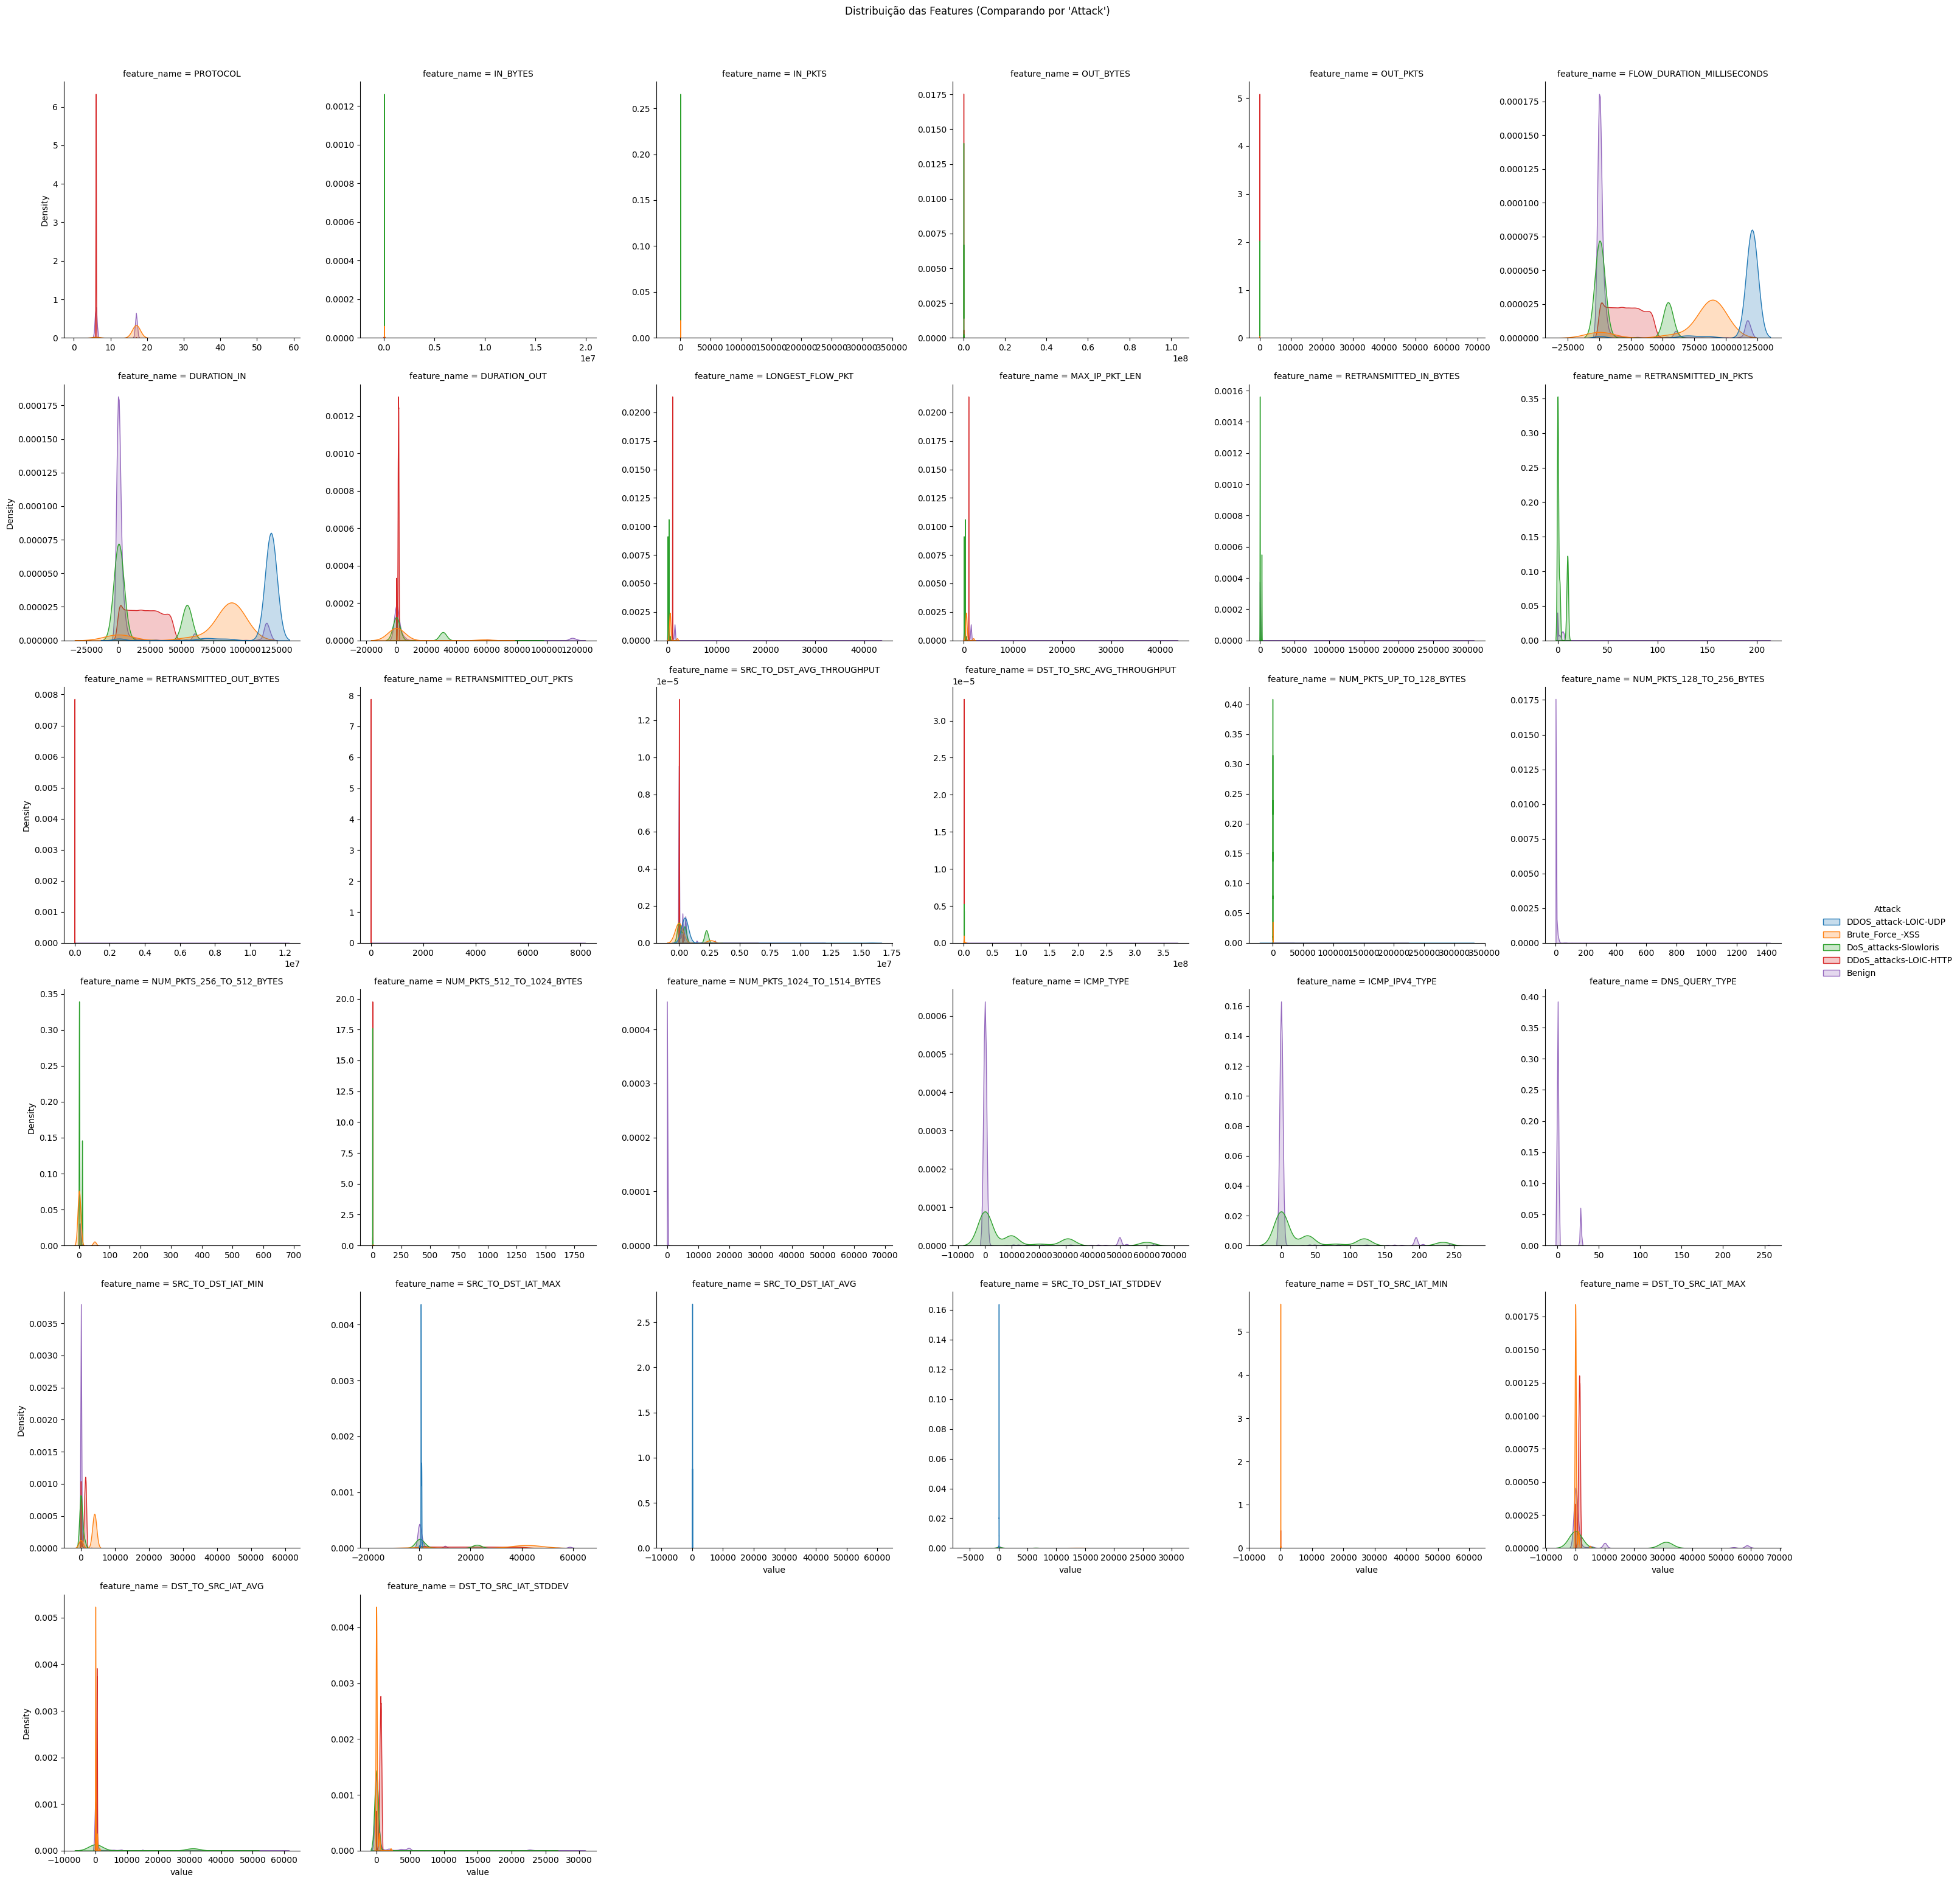

In [58]:
id_vars = ['Attack', 'Label']
df_melted = df_val.melt(id_vars=id_vars,
                    value_vars=feature_names,
                    var_name='feature_name',
                    value_name='value')

g = sns.displot(
    data=df_melted,
    x='value',
    kind='kde',
    col='feature_name',
    hue='Attack',
    col_wrap=6,
    fill=True,
    common_norm=False,
    facet_kws={'sharey': False, 'sharex': False}
)
g.fig.suptitle("Distribuição das Features (Comparando por 'Attack')", y=1.03)